# 3.9.1: Baseball  (Vectors)

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


As the course has developed, we have moved closer and closer to realistic models of the physical world.  In this notebook, we're going to creep even closer: by including a second dimension in our model!

<br>

We'll look at the flight of a baseball including the effect
of air resistance, and later incorporate that into an optimization problem.  Before we do that, though, we need to understand how to track an object in two dimensions.  We need to understand vectors.

## Vectors

Now that we are working in two dimensions, it will be useful to
work with *vector quantities*.  Broadly defined, a vector represents any quantity whose expression requires more than one value. In physics and engineering, a vector is most often quantity that is defined by both a magnitude and a direction.  We will use vectors to represent positions, velocities, accelerations, and forces in two and three dimensions.  The "opposite" of a vector is a *scalar*, which is a quanity that can be defined with a single value (like mass, density, etc...).

### Working with vector components

A vector for a multidimensional quanity like velocity or force can be represented in two ways: as a magnitude and direction, or as a pair of components.  The vector arrow in this image, could be fully defined either by defining the length of the vector $A$ and the angle $\theta _A$, $or$ by defining the x- and y-*components*, denoted here by $A.x$ and $A.y$:

<br>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/vector_mag.png width = 400>

<br>

We tend to think of vectors in terms of angles and length, but vector math is generally easier using the components, which allow us to work in Cartesian coordinates rather than polar coordinates.  So when we create a vector in Python, we'll use Pandas `Series` to store the components of the vector, and then "translate" to angles and magnitudes when necessary.  

<br>

So the following represents a point 5 units to the right (or east) and 2 units up (or north) from an implicit origin:

In [ ]:


A = pd.Series(dict(x=5.0,y=2.0), dtype=float)
A

x    5.0
y    2.0
dtype: float64

As with any `Series`, you can access the components of a vector by name using the dot
operator, or by using using their index in brackets:

In [ ]:
print(A.x, A[0], A.y, A[1])

5.0 5.0 2.0 2.0


It is useful that `Series` objects support most mathematical operations, including
addition and subtraction.  The mathematical rules for vectors are quite similar to those for scalars.

In [ ]:
B = pd.Series(dict(x=2.0,y=3.0), dtype=float)
R = A + B
R

x    7.0
y    5.0
dtype: float64

Adding two vectors means that we are putting them head to tail, and finding the vector that goes from the beginning point of the first vector to the end point of the second vector.  This image displays graphically the addition problem that we just completed computationally:

<br>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/vector.PNG width = 400>




### Working with vector angles

We can specify a vector with coordinates `x` and `y`, as in the previous examples.  Often, though, we want to specify a vector with a magnitude and angle.  *Magnitude* is the length of the vector: if the vector represents a position, magnitude is its distance from the origin; if it represents a velocity, magnitude is its speed. 

<br>

We want to be able to "translate" a component expression of a vector to a magnitude-angle expression. To find a magnitude, we use the Pythagorean theorem in the following form:

$$A_{mag} = \sqrt{A_x^2 + A_y^2}$$

In [ ]:
mag = np.sqrt(A.x**2 + A.y**2)
mag

5.385164807134504

To find the direction of a vector, expressed as an angle $\theta$ in radians from the positive $x$ axis, we need to use trigonometry.  If you remember "SOH CAH TOA" from trigonometry, you know that "TOA" represents $tan ~ \theta = \frac{opposite}{adjacent}$.  

<br>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/vector_mag.png width = 400>

<br>

Since we know the two sides of the triangle, we can use this equation to find $\theta$:

<br>

$$\theta = tan^{-1} \frac{y}{x}$$

<br>


The *inverse tangent* is sometimes denoted as *arctan*, which explains the name of this NumPy function:

In [ ]:
theta = np.arctan2(A.y, A.x)
theta

0.3805063771123649

The result from here is in radians.  Most Python functions, like `sin` and `cos`, work with radians.  Many people find it more natural to work with degrees, and NumPy provides another function to convert radians to degrees:

In [ ]:
from numpy import rad2deg

angle = rad2deg(theta)
angle

21.80140948635181

And a function to convert degrees to radians:

In [ ]:
from numpy import deg2rad

theta = deg2rad(angle)
theta

0.3805063771123649

To avoid confusion, we'll use the variable name `angle` for a value in degrees and `theta` for a value in radians.

<br>

We can also work the other way: if we are given an angle and magnitude, we can make a vector using defined by its components. Remembering our trignometric tools, we can make a simple function to do this work for us:


In [ ]:
def angle_to_components(mag,angle):
    theta = deg2rad(angle)
    x = mag * np.cos(theta)
    y = mag * np.sin(theta)
    return pd.Series(dict(x=x,y=y),dtype=float)

D = angle_to_components(10,60)
D

x    5.000000
y    8.660254
dtype: float64

Now let's get back to the game!

## A Model for Baseball Flight

To model the flight of a baseball, we have to make some decisions. To get started, we'll ignore any spin that might be on the ball, and the resulting [Magnus force](https://https://en.wikipedia.org/wiki/Magnus_effect). Under this assumption, the ball travels in a vertical plane, so we'll run simulations in two dimensions, rather than three.

<br>

To model air resistance, we'll need the mass, frontal area, and drag
coefficient of a baseball. Mass and diameter are easy to find. Drag coefficient is only a little harder; according to *The Physics of Baseball*, the drag coefficient of a baseball is approximately 0.33 (with no units).  However, this value *does* depend on velocity. At low velocities it
might be as high as 0.5, and at high velocities as low as 0.28.
Furthermore, the transition between these regimes typically happens
exactly in the range of velocities we are interested in, between 20 m/s and 40 m/s.

<br>

Nevertheless, we'll start with a simple model where the drag coefficient does not depend on velocity; as an exercise at the end of the notebook, you can implement a more detailed model and see what effect it has on the results.

### A system and state in 2D

Let's simulate the flight of a baseball that is batted from home plate
at an angle of 45° and initial speed 40 m/s. We'll use the center of home plate as the origin, a horizontal x-axis (parallel to the ground), and a vertical y-axis (perpendicular to the ground). The initial height is 1 m.

<br>

Here's a `Params` object with the parameters we'll need.

In [ ]:
params = dict(
    x = 0,          # m
    y = 1,          # m
    angle = 45,     # degree
    speed = 40,     # m / s

    mass = 0.145,    # kg 
    diameter = 0.073, # m 
    C_d = 0.33,       # dimensionless

    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10)     # s

The mass and diameter of the baseball are standard values, and the density of air, `rho`, is based on a temperature of 20 °C at sea level.
`t_end` is 10 seconds, which is long enough for the ball to land on the ground.

<br>

The following function uses these quantities to make a `system` object.

In [ ]:
from numpy import pi, deg2rad

def make_system(params):
    
    x, y, angle, speed, mass, diameter, C_d, rho, g, t_end = params.values()
    
    # compute x and y components of velocity
    init_vel = angle_to_components(speed, angle)
    
    # make the initial state
    init = pd.Series(dict(x=x, y=y, vx=init_vel.x, vy=init_vel.y))
    
    # compute the frontal area
    area = pi * (diameter/2)**2

    return dict(C_d=C_d, rho=rho, g=g, t_end=t_end,
                  mass=mass,
                  init = init,
                  area = area)

One of the great things about solving 2D problems is that we can separate the velocities and positions into two separate but connected problems. In other words, the velocity in the y-direction is affected only by forces that act in the y-direction, and that velocity causes a change in position only in the y-direction.  This is a enormously helpful way to evaluate a problem like this.  So we want to separate the velocities into x-velocities and y-velocities.

<br>

To do this, we make `init` as a `State` object with four state variables:

* `x` and `y` are the components of position.

* `vx` and `vy` are the components of velocity.

When we call `System`, we pass `Params` as the first argument, which means that the variables in `Params` are copied to the new `System` object.

<br>

Here's how we make the `System` object and the initial state:

In [ ]:
system = make_system(params)
system['init']

x      0.000000
y      1.000000
vx    28.284271
vy    28.284271
dtype: float64

### Drag force in 2D

From here on, the implementation follows the same path that we used in our earlier dynamics problems: define the forces, use these to define the acceleration, and then solve the initial value problem.  We just have to remember to put all of our quantities (force, position, velocity, and acceleration) in component vector form.

<br>

We'll start by building a function to compute drag force:

In [ ]:
def drag_force(V, system):
    rho, C_d, area = system['rho'], system['C_d'], system['area']
    
    # Find the magnitude and direction of the velocity
    vel_mag = np.sqrt(V.x**2 + V.y**2)
    dir = V/vel_mag

    # Find the magnitude of the drag force
    drag_mag = rho * vel_mag**2 * C_d * area * (1/2)

    # Define the direction of the force as opposite that of the  velocity
    # Notice that "dir" is a vector, so f_drag is vector too
    f_drag = drag_mag * -dir

    return f_drag

This function takes `V` as a component vector and returns `f_drag` as a component vector pointed in the opposite direction: 

* It computes the magnitude of `V` using the Pythagorean theorem.

* It divides `V` by its magnitude, which produces a vector of a single unit in the same direction.

* It uses the drag equation to compute the magnitude of the drag force, `mag`.

* Finally, it computes the drag force vector by multiplying `mag` and `dir`.

We can test it like this:

In [ ]:
V_test = pd.Series(dict(x = 1, y = 1))
f_drag = drag_force(V_test, system)
f_drag

x   -0.001172
y   -0.001172
dtype: float64

The result is a vector that represents the drag force on the baseball, in Newtons, under the initial conditions.  

### A slope function in 2D

Now that we have defined drag force, we can add it to gravity in the slope function: 

In [ ]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system['mass'], system['g']
    
    V = pd.Series(dict(x=vx, y=vy),dtype=float)
    a_drag = drag_force(V, system) / mass

    # Acceleration has to be defined as a vector too
    a_grav = pd.Series(dict(x=0,y=-g),dtype=float)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y  

As usual, the parameters of the slope function are a time stamp, a `State` object, and a `System` object. 
We don't use `t` in this example, but we can't leave it out because when `run_solve_ivp` calls the slope function, it always provides the same arguments, whether they are needed or not.

<br>

`slope_func` unpacks the `State` object into variables `x`, `y`, `vx`, and `vy`.
Then it packs `vx` and `vy` into a vector, which it uses to compute drag force, `f_drag`,  and acceleration due to drag, `a_drag`.  To represent acceleration due to gravity, it makes a vector with magnitude `g` in the negative $y$ direction.  The total acceleration of the baseball, `A`, is the sum of accelerations due to gravity and drag.

<br>

The return value is a sequence that contains the derivatives of position (`V.x` and `V.y`) and velocity (`A.x` and `A.y`) in the two component directions.  These components represent the slope of the state variables, because `V` is the derivative of position and `A` is the derivative of velocity.

<br>

As always, we can test the slope function by running it with the initial conditions:

In [ ]:
slope_func(0, system['init'], system)

(28.284271247461902, 28.2842712474619, -6.466030881564545, -16.266030881564546)

Using vectors to represent forces and accelerations makes the code
concise, readable, and less error-prone. 

### Adding an event function

We're almost ready to run the simulation.  The last thing we need is an event function that stops when the ball hits the ground--that is, when the y-component of position is zero:

In [ ]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

The event function takes the same parameters as the slope function, and returns the $y$ coordinate of position. When `event_func` is used as an option with `run_solve_ivp`, the simulation will stop when the return value (i.e the $y$ coordinate) passes through 0.

<br>

As we did with `slope_func`, we can test `event_func` with the initial conditions.

In [ ]:
event_func(0, system['init'], system)

1.0

Here's how we run the simulation with this event function:

In [ ]:
results, details = run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

The message in indicates that a "termination event" occurred; that is, the simulated ball reached the ground. 

## Understanding the Results

Now we can look at our results.  `results` is a `DataFrame` with one column for each of the state variables:

In [ ]:
results.tail()

,x,y,vx,vy
4.804692,96.438515,4.284486,14.590855,-20.726780
4.854740,97.166460,3.238415,14.484772,-21.065476
4.904789,97.889087,2.175515,14.378566,-21.400392
4.954838,98.606374,1.095978,14.272264,-21.731499
5.004887,99.318296,0.000000,14.165894,-22.058763


We can get the flight time like this:

In [ ]:
flight_time = results.index[-1]
flight_time

5.004887034868346

And the final state like this:

In [ ]:
final_state = results.iloc[-1]
final_state

x     99.318296
y      0.000000
vx    14.165894
vy   -22.058763
Name: 5.004887034868346, dtype: float64

The final value of `y` is close to 0, as it should be.  The final value of `x` tells us how far the ball flew, in meters.  We can find magnitude of final velocity when it lands.

In [ ]:
np.sqrt(final_state.vx**2 +final_state.vy**2)

26.215674453237572

The final speed is about 26 m/s, which is substantially slower than the initial speed, 40 m/s.

### Visualizing 2D motion

To visualize the results, we can plot the $x$ and $y$ components of position like this:

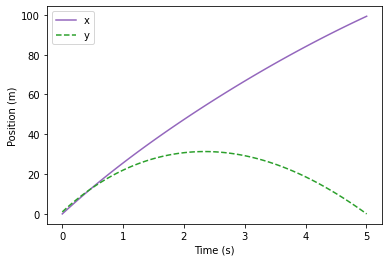

In [ ]:
results.x.plot(color='C4',legend=True)
results.y.plot(color='C2', style='--',xlabel='Time (s)',
         ylabel='Position (m)',legend=True);

As expected, the $x$ component increases as the ball moves away from home plate. The $y$ position climbs initially and then descends, falling to 0 m near 5.0 s.  Notice that the green line is *not* the trajectory of the ball!

<br>

If we want to see the trajectory, we can plot the $x$ component on the
$x$-axis and the $y$ component on the $y$-axis.  We'll make a short function to do this.  Notice that we're defining the `figsize`, so the scale of the two axes are about the same, which allows us to better visualize the flight of the ball:

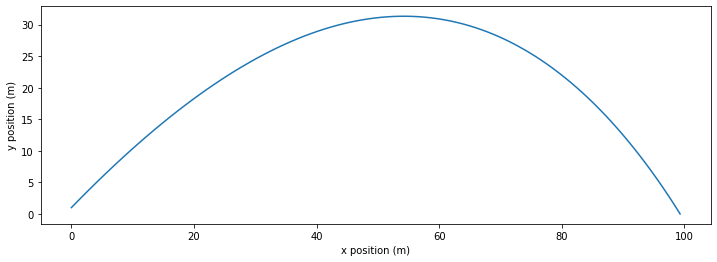

In [ ]:
def plot_trajectory(results,label,**options):
    x = results.x.values
    y = results.y.values
    x_vs_y = pd.Series(data=y,index=x)
    x_vs_y.plot(label=label,xlabel='x position (m)',
             ylabel='y position (m)',figsize=[12,4],**options)

plot_trajectory(results,'trajectory')

A trajectory plot can be easier to interpret than a time series plot,
because it shows what the motion of the projectile would look like (at
least from one point of view). Both plots can be useful, but don't get
them mixed up! If you are looking at a time series plot and interpreting it as a trajectory, you will be very confused.

<br>

Notice that the trajectory is not symmetric.
With a launch angle of 45°, the landing angle is closer to vertical, about 57° degrees.

In [ ]:
rad2deg(np.arctan2(final_state.vy,final_state.vx))

-57.29187097821225

---

<br>

## Exercises

### Exercise 1

 Run the simulation with and without air resistance.  How wrong would we be if we ignored drag?

In [ ]:
# Hint

system2 = system.copy()
system2.update(dict(C_d=0))

In [ ]:
# Run the simulation
results2, details = run_solve_ivp(system2, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

In [ ]:
# Compare the total time, the maximum height, and total distance in the x-direction

diff_time = results2.index[-1]-results.index[-1]
diff_max_height = results2.y.max()-results.y.max()
diff_distance = results2.iloc[-1].x-results.iloc[-1].x

print(diff_time, diff_max_height, diff_distance)

#  The difference is by no means trivial!  The ball without drag flies about 65% 
# farther and 50% higher than the ball with drag

0.8025546201423595 10.482389652866136 64.94095874060983


### Exercise 2

 The baseball stadium in Denver, Colorado is 1,580 meters above sea level, where the density of air is about 1.0 kg / m$^3$.  How much farther would a ball hit with the same initial speed and launch angle travel than the ball at sea level?

In [ ]:
# Set the parameters for a system3

system3 = system.copy()
system3.update(dict(rho=1))

In [ ]:
# Run the simulation
results3, details = run_solve_ivp(system3, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

In [ ]:
# Compare the total time, the maximum height, and total distance in the x-direction

diff_time = results3.index[-1]-results.index[-1]
diff_max_height = results3.y.max()-results.y.max()
diff_distance = results3.iloc[-1].x-results.iloc[-1].x

print(diff_time, diff_max_height, diff_distance)

#  In the "thinner" air in Denver a similarly hit ball might
# travel 6.5 m (about 20 ft) further.  Again, not a trivial
# distance, especially if it's the ninth inning and the game
# is tied.

0.10224411013264234 1.2377490967195577 6.4700837750757785
